# b-tagging Machine Learning 
## Sample preparation

https://www.datacourses.com/manage-nan-values-in-a-dataframe-235/
https://towardsdatascience.com/whats-the-best-way-to-handle-nan-values-62d50f738fc
machine learning missing data - google

In [1]:
import tracemalloc

tracemalloc.start()

current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")


Current memory usage is 0.000505MB; Peak was 0.01053MB


In [2]:
# importing necessary packages
import h5py
import numpy as np
from numpy.lib.recfunctions import repack_fields
import pandas as pd
import json
from keras.utils import np_utils
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
file_path =  "/eos/user/v/vcondeme/HI_btagging_LIP/b_tagging_lip"
new_file_path ="/eos/user/v/vcondeme/HI_btagging_LIP/b_tagging_lip"

![alt text](img/downsampling.png)
First we define the downsampling of the samples. The principle is shown in the image above. In each pT and |eta| bin the same amount of jets are inserted for each flavour category (light, c- and b-jets). This is an alternative approach to re-weighting the pT and |eta| distributions in order to keep the training weights to 1.

In [4]:
Zprime_file = new_file_path + "/JZ1_5_even.h5"
df_Zprime = h5py.File(Zprime_file, "r")['jets'][:] ### all 

In [5]:
test_file = new_file_path + "/JZ1_5_odd.h5"
df_test = h5py.File(test_file, "r")['jets'][:] ### all 

In [6]:

current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6561.602998MB; Peak was 6561.656276MB


In [7]:
print(df_Zprime.size)
print(df_test.size)
df_Zprime = np.concatenate((df_Zprime, df_test))
print(df_Zprime.size)

8368659
8380435
16749094


In [8]:
print(df_Zprime.shape)

(16749094,)


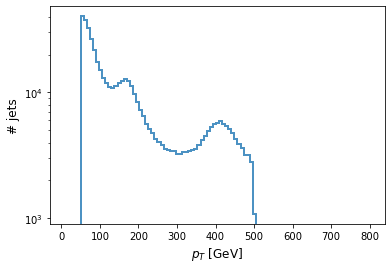

In [9]:
binning = {"jet_pt": np.linspace(10000, 800000, 100),#/1000,
               "jet_eta": np.linspace(0, 2.5, 26)}
var = "jet_pt"

plt.hist(df_Zprime[df_Zprime['HadronConeExclTruthLabelID']==5][var]/1000, binning[var]/1000, histtype='step',
         label=["b-jets"], 
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)

plt.xlabel('$p_T$ [GeV]',fontsize=12)
plt.ylabel('# jets',fontsize=12)
plt.yscale('log')
#plt.legend()

In [10]:
##Dividir os sets
validation_percentage = 0.02
test_percentage = 0.02
training_percentage = 1-validation_percentage-test_percentage

sample_size = df_Zprime.size
training_size = int(sample_size*training_percentage)
validation_size = int(sample_size*validation_percentage)

##shuffling
np.random.shuffle(df_Zprime)

training_set = df_Zprime[:training_size]
validation_set = df_Zprime[training_size:training_size+validation_size]
test_set = df_Zprime[training_size+validation_size:]

In [11]:
print(training_set.size)
print(validation_set.size)
print(test_set.size)
print(training_set.size+validation_set.size+test_set.size)

16079130
334981
334983
16749094


In [12]:
from numpy.lib.recfunctions import repack_fields
def DownSampling(bjets, cjets, ujets):
    # pT in MeV
    pt_bins = np.linspace(0, 800000, 100)
    #pt_bins = np.linspace(0, 200000, 10)
    eta_bins = np.linspace(-2.5, 2.5, 10)
    
    

    histvals_b, _, _ = np.histogram2d(bjets['jet_eta'], bjets['jet_pt'],
                                [eta_bins, pt_bins])
    histvals_c, _, _ = np.histogram2d(cjets['jet_eta'], cjets['jet_pt'],
                                [eta_bins, pt_bins])
    histvals_u, _, _ = np.histogram2d(ujets['jet_eta'], ujets['jet_pt'],
                                [eta_bins, pt_bins])

    b_locations_pt = np.digitize(bjets['jet_pt'], pt_bins) - 1
    b_locations_eta = np.digitize(bjets['jet_eta'], eta_bins) - 1
    b_locations = zip(b_locations_pt, b_locations_eta)
    b_locations = list(b_locations)

    c_locations_pt = np.digitize(cjets['jet_pt'], pt_bins) - 1
    c_locations_eta = np.digitize(cjets['jet_eta'], eta_bins) - 1
    c_locations = zip(c_locations_pt, c_locations_eta)
    c_locations = list(c_locations)

    u_locations_pt = np.digitize(ujets['jet_pt'], pt_bins) - 1
    u_locations_eta = np.digitize(ujets['jet_eta'], eta_bins) - 1
    u_locations = zip(u_locations_pt, u_locations_eta)
    u_locations = list(u_locations)

    c_loc_indices = { (pti, etai) : [] for pti,_ in enumerate(pt_bins[::-1]) for etai,_ in enumerate(eta_bins[::-1])}
    b_loc_indices = { (pti, etai) : [] for pti,_ in enumerate(pt_bins[::-1]) for etai,_ in enumerate(eta_bins[::-1])}
    u_loc_indices = { (pti, etai) : [] for pti,_ in enumerate(pt_bins[::-1]) for etai,_ in enumerate(eta_bins[::-1])}
    print('Grouping the bins')
    for i, x in enumerate(c_locations):
        #print ('i: ', i , 'x: ', x )
        c_loc_indices[x].append(i)

    for i, x in enumerate(b_locations):
        b_loc_indices[x].append(i)

    for i, x in enumerate(u_locations):
        u_loc_indices[x].append(i)

    cjet_indices = []
    bjet_indices = []
    ujet_indices = []
    print('Matching the bins for all flavours')
    for pt_bin_i in range(len(pt_bins) - 1):
        for eta_bin_i in range(len(eta_bins) - 1):
            loc = (pt_bin_i, eta_bin_i)

            nbjets = int(histvals_b[eta_bin_i][pt_bin_i])
            ncjets = int(histvals_c[eta_bin_i][pt_bin_i])
            nujets = int(histvals_u[eta_bin_i][pt_bin_i])

            njets = min([nbjets, ncjets, nujets])
            c_indices_for_bin = c_loc_indices[loc][0:njets]
            b_indices_for_bin = b_loc_indices[loc][0:njets]
            u_indices_for_bin = u_loc_indices[loc][0:njets]
            cjet_indices += c_indices_for_bin
            bjet_indices += b_indices_for_bin
            ujet_indices += u_indices_for_bin

    cjet_indices.sort()
    bjet_indices.sort()
    ujet_indices.sort()
    return np.array(bjet_indices), np.array(cjet_indices), np.array(ujet_indices)

In [13]:
def Gen_default_dict(scale_dict):
    """Generates default value dictionary from scale/shift dictionary."""
    default_dict = {}
    for elem in scale_dict:
        if 'isDefaults' in elem['name']:
            continue
        default_dict[elem['name']] = elem['default']
    return default_dict

In [14]:

def ScaleVariables(bjets, cjets, ujets):
    with open("params_MC16D-ext_2018-PFlow_70-8M_mu.json", 'r') as infile:
        scale_dict = json.load(infile)
    bjets = pd.DataFrame(bjets)
    cjets = pd.DataFrame(cjets)
    ujets = pd.DataFrame(ujets)
    bjets.replace([np.inf, -np.inf], np.nan, inplace=True)
    cjets.replace([np.inf, -np.inf], np.nan, inplace=True)
    ujets.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Replace NaN values with default values from default dictionary
    default_dict = Gen_default_dict(scale_dict)
    bjets.fillna(default_dict, inplace=True)
    cjets.fillna(default_dict, inplace=True)
    ujets.fillna(default_dict, inplace=True)
    # scale and shift distribution
    for elem in scale_dict:
        if 'isDefaults' in elem['name']:
            continue
        if elem['name'] not in var_names:
            continue
        else:
            bjets[elem['name']] = ((bjets[elem['name']] - elem['shift']) /
                                  elem['scale'])
            cjets[elem['name']] = ((cjets[elem['name']] - elem['shift']) /
                                  elem['scale'])
            ujets[elem['name']] = ((ujets[elem['name']] - elem['shift']) /
                                  elem['scale'])
    return bjets.to_records(index=False, column_dtypes='float64'), cjets.to_records(index=False, column_dtypes='float64'), ujets.to_records(index=False, column_dtypes='float64')


In [15]:
del df_test
del df_Zprime
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6564.775151MB; Peak was 12993.269906MB


Primeiro validation e test set

In [16]:
with open("HI_DL1r_Variables.json") as vardict:
    var_names = json.load(vardict)[:]

In [17]:
if 'HadronConeExclTruthLabelID' in var_names:
    var_names.remove('HadronConeExclTruthLabelID')

In [18]:
with open("params_MC16D-ext_2018-PFlow_70-8M_mu.json", 'r') as infile:
    scale_dict = json.load(infile)

In [19]:
jets = pd.DataFrame(validation_set)
    
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6693.487547MB; Peak was 12993.269906MB


In [20]:
del validation_set

In [21]:
pd.show_versions()
print(jets.shape)


INSTALLED VERSIONS
------------------
commit           : 7d32926db8f7541c356066dcadabf854487738de
python           : 3.8.6.final.0
python-bits      : 64
OS               : Linux
OS-release       : 3.10.0-1160.6.1.el7.x86_64
Version          : #1 SMP Tue Nov 17 13:59:11 UTC 2020
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.2.2
numpy            : 1.18.2
pytz             : 2019.1
dateutil         : 2.8.0
pip              : 19.1.1
setuptools       : 44.1.0
Cython           : 0.29.20
pytest           : 6.1.1
hypothesis       : 5.3.0
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.6.2
html5lib         : 1.0.1
pymysql          : None
psycopg2         : None
jinja2           : 2.10.1
IPython          : 7.5.0
pandas_datareader: None
bs4              : None
bottleneck       : None


In [22]:
print("check key", "HadronConeExclTruthLabelID" in jets.columns.values)
jets.query('(HadronConeExclTruthLabelID<=5)', inplace=True)

check key True


In [23]:
labels = jets.loc[:, 'HadronConeExclTruthLabelID'].values

In [24]:
print(jets.size)

26463499


In [25]:
jets = jets.loc[:, var_names]

In [26]:
jets.replace([np.inf, -np.inf], np.nan, inplace=True)

In [27]:
    # Replace NaN values with default values from default dictionary
default_dict = Gen_default_dict(scale_dict)
jets.fillna(default_dict, inplace=True)

In [28]:
 # scale and shift distribution
for elem in scale_dict:
    if 'isDefaults' in elem['name']:
        continue
    if elem['name'] not in var_names:
        continue
    else:
        jets[elem['name']] = ((jets[elem['name']] - elem['shift']) / elem['scale']) #causes caveats
            #jets.loc[elem['name']] = ((jets[elem['name']] - elem['shift']) / elem['scale']) # causes (in DL1_Training) ValueError: Data cardinality is ambiguous: x sizes: 2203905, 2203869
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6718.992851MB; Peak was 12993.269906MB


In [29]:
labels_cat = np.copy(labels)
labels_cat[labels_cat==5] = 2
labels_cat[labels_cat==4] = 1
labels_cat = np_utils.to_categorical(labels_cat, 3)
print ('labels', labels)
print ('len labels', len(labels))
print ('type of labels', type(labels))
print ('shape of labels', labels.shape)
print ('example values', labels[110])
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

labels [0 0 0 ... 0 0 0]
len labels 334981
type of labels <class 'numpy.ndarray'>
shape of labels (334981,)
example values 0
Current memory usage is 6723.032926MB; Peak was 12993.269906MB


In [30]:
outfile_name = "three_datasets/validation_2.h5"
h5f = h5py.File(outfile_name, 'w')
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6723.034646MB; Peak was 12993.269906MB


In [31]:
h5f.create_dataset('X_validation', data=jets.values, compression='gzip')
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6723.030728MB; Peak was 12993.269906MB


In [32]:
del jets 
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6609.146323MB; Peak was 12993.269906MB


In [33]:
h5f.create_dataset('Y_validation', data=labels_cat, compression='gzip')
h5f.close()

In [34]:
del labels_cat
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6605.139735MB; Peak was 12993.269906MB


In [35]:
jets = pd.DataFrame(test_set)
del test_set
print("check key", "HadronConeExclTruthLabelID" in jets.columns.values)
jets.query('(HadronConeExclTruthLabelID<=5)', inplace=True)
labels = jets.loc[:, 'HadronConeExclTruthLabelID'].values
jets = jets.loc[:, var_names]
jets.replace([np.inf, -np.inf], np.nan, inplace=True)
default_dict = Gen_default_dict(scale_dict)
jets.fillna(default_dict, inplace=True)

check key True


In [36]:
 # scale and shift distribution
for elem in scale_dict:
    if 'isDefaults' in elem['name']:
        continue
    if elem['name'] not in var_names:
        continue
    else:
        jets[elem['name']] = ((jets[elem['name']] - elem['shift']) / elem['scale']) #causes caveats
            #jets.loc[elem['name']] = ((jets[elem['name']] - elem['shift']) / elem['scale']) # causes (in DL1_Training) ValueError: Data cardinality is ambiguous: x sizes: 2203905, 2203869
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6719.078054MB; Peak was 12993.269906MB


In [37]:
labels_cat = np.copy(labels)
labels_cat[labels_cat==5] = 2
labels_cat[labels_cat==4] = 1
labels_cat = np_utils.to_categorical(labels_cat, 3)
print ('labels', labels)
print ('len labels', len(labels))
print ('type of labels', type(labels))
print ('shape of labels', labels.shape)
print ('example values', labels[110])
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

labels [0 0 0 ... 0 0 0]
len labels 334983
type of labels <class 'numpy.ndarray'>
shape of labels (334983,)
example values 0
Current memory usage is 6723.100079MB; Peak was 12993.269906MB


In [38]:
outfile_name = "three_datasets/test_2.h5"
h5f = h5py.File(outfile_name, 'w')
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6723.095404MB; Peak was 12993.269906MB


In [39]:
h5f.create_dataset('X_test', data=jets.values, compression='gzip')
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6723.076435MB; Peak was 12993.269906MB


In [40]:
del jets 
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6609.189326MB; Peak was 12993.269906MB


In [41]:
h5f.create_dataset('Y_test', data=labels_cat, compression='gzip')
h5f.close()

In [42]:
del labels_cat
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6605.180424MB; Peak was 12993.269906MB


In [43]:
bjets = training_set[training_set['HadronConeExclTruthLabelID']==5]
cjets = training_set[training_set['HadronConeExclTruthLabelID']==4]
ujets = training_set[training_set['HadronConeExclTruthLabelID']==0]

In [44]:
del training_set
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")

Current memory usage is 6347.937399MB; Peak was 12993.269906MB


In [45]:



print('b: ', bjets.size)
print('c: ', cjets.size)
print('u: ', ujets.size)
initial_size = bjets.size + cjets.size + ujets.size 
bjet_indices, cjet_indices, ujet_indices = DownSampling(bjets, cjets, ujets)

b:  470742
c:  979682
u:  14628706
Grouping the bins
Matching the bins for all flavours


Due to the different $p_T$ distributions of the b-, c-, and light flavour jets, we need a factor 2-3 more c- and light flavour jets as input for the downsampling.

In [46]:
Njets = 100000000 
nZ = int(Njets*3*(1/0.65-1))
ncjets = int(2.3 * Njets)
nujets = int(2.7 * Njets)

Please change the diretory to your path where you have the files stored

In [47]:
bjets = bjets[bjet_indices]
cjets = cjets[cjet_indices]
ujets = ujets[ujet_indices]

In [48]:
print('b: ', bjets.size)
print('c: ', cjets.size)
print('u: ', ujets.size)
final_size = bjets.size + cjets.size + ujets.size 
print("initial size: " + str(initial_size) + "\n final size: " + str(final_size) + "\n percentagem: " + str(final_size/initial_size))

b:  470739
c:  470739
u:  470739
initial size: 16079130
 final size: 1412217
 percentagem: 0.08782919225107329


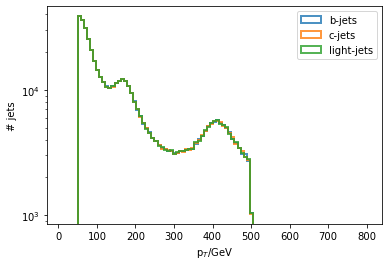

In [49]:
plt.hist(bjets[var]/1000, binning[var]/1000, histtype='step',
         label=["b-jets"],
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
plt.hist(cjets[var]/1000, binning[var]/1000, histtype='step',
         label=["c-jets"], 
         stacked=False, 
         fill=False, 
         linewidth=2, alpha=0.8)
plt.hist(ujets[var]/1000, binning[var]/1000, histtype='step',
         label=["light-jets"],
         stacked=False, 
         fill=False,
         linewidth=2, alpha=0.8)
plt.xlabel('p$_T$/GeV')
plt.ylabel('# jets')
plt.yscale('log')
plt.legend()

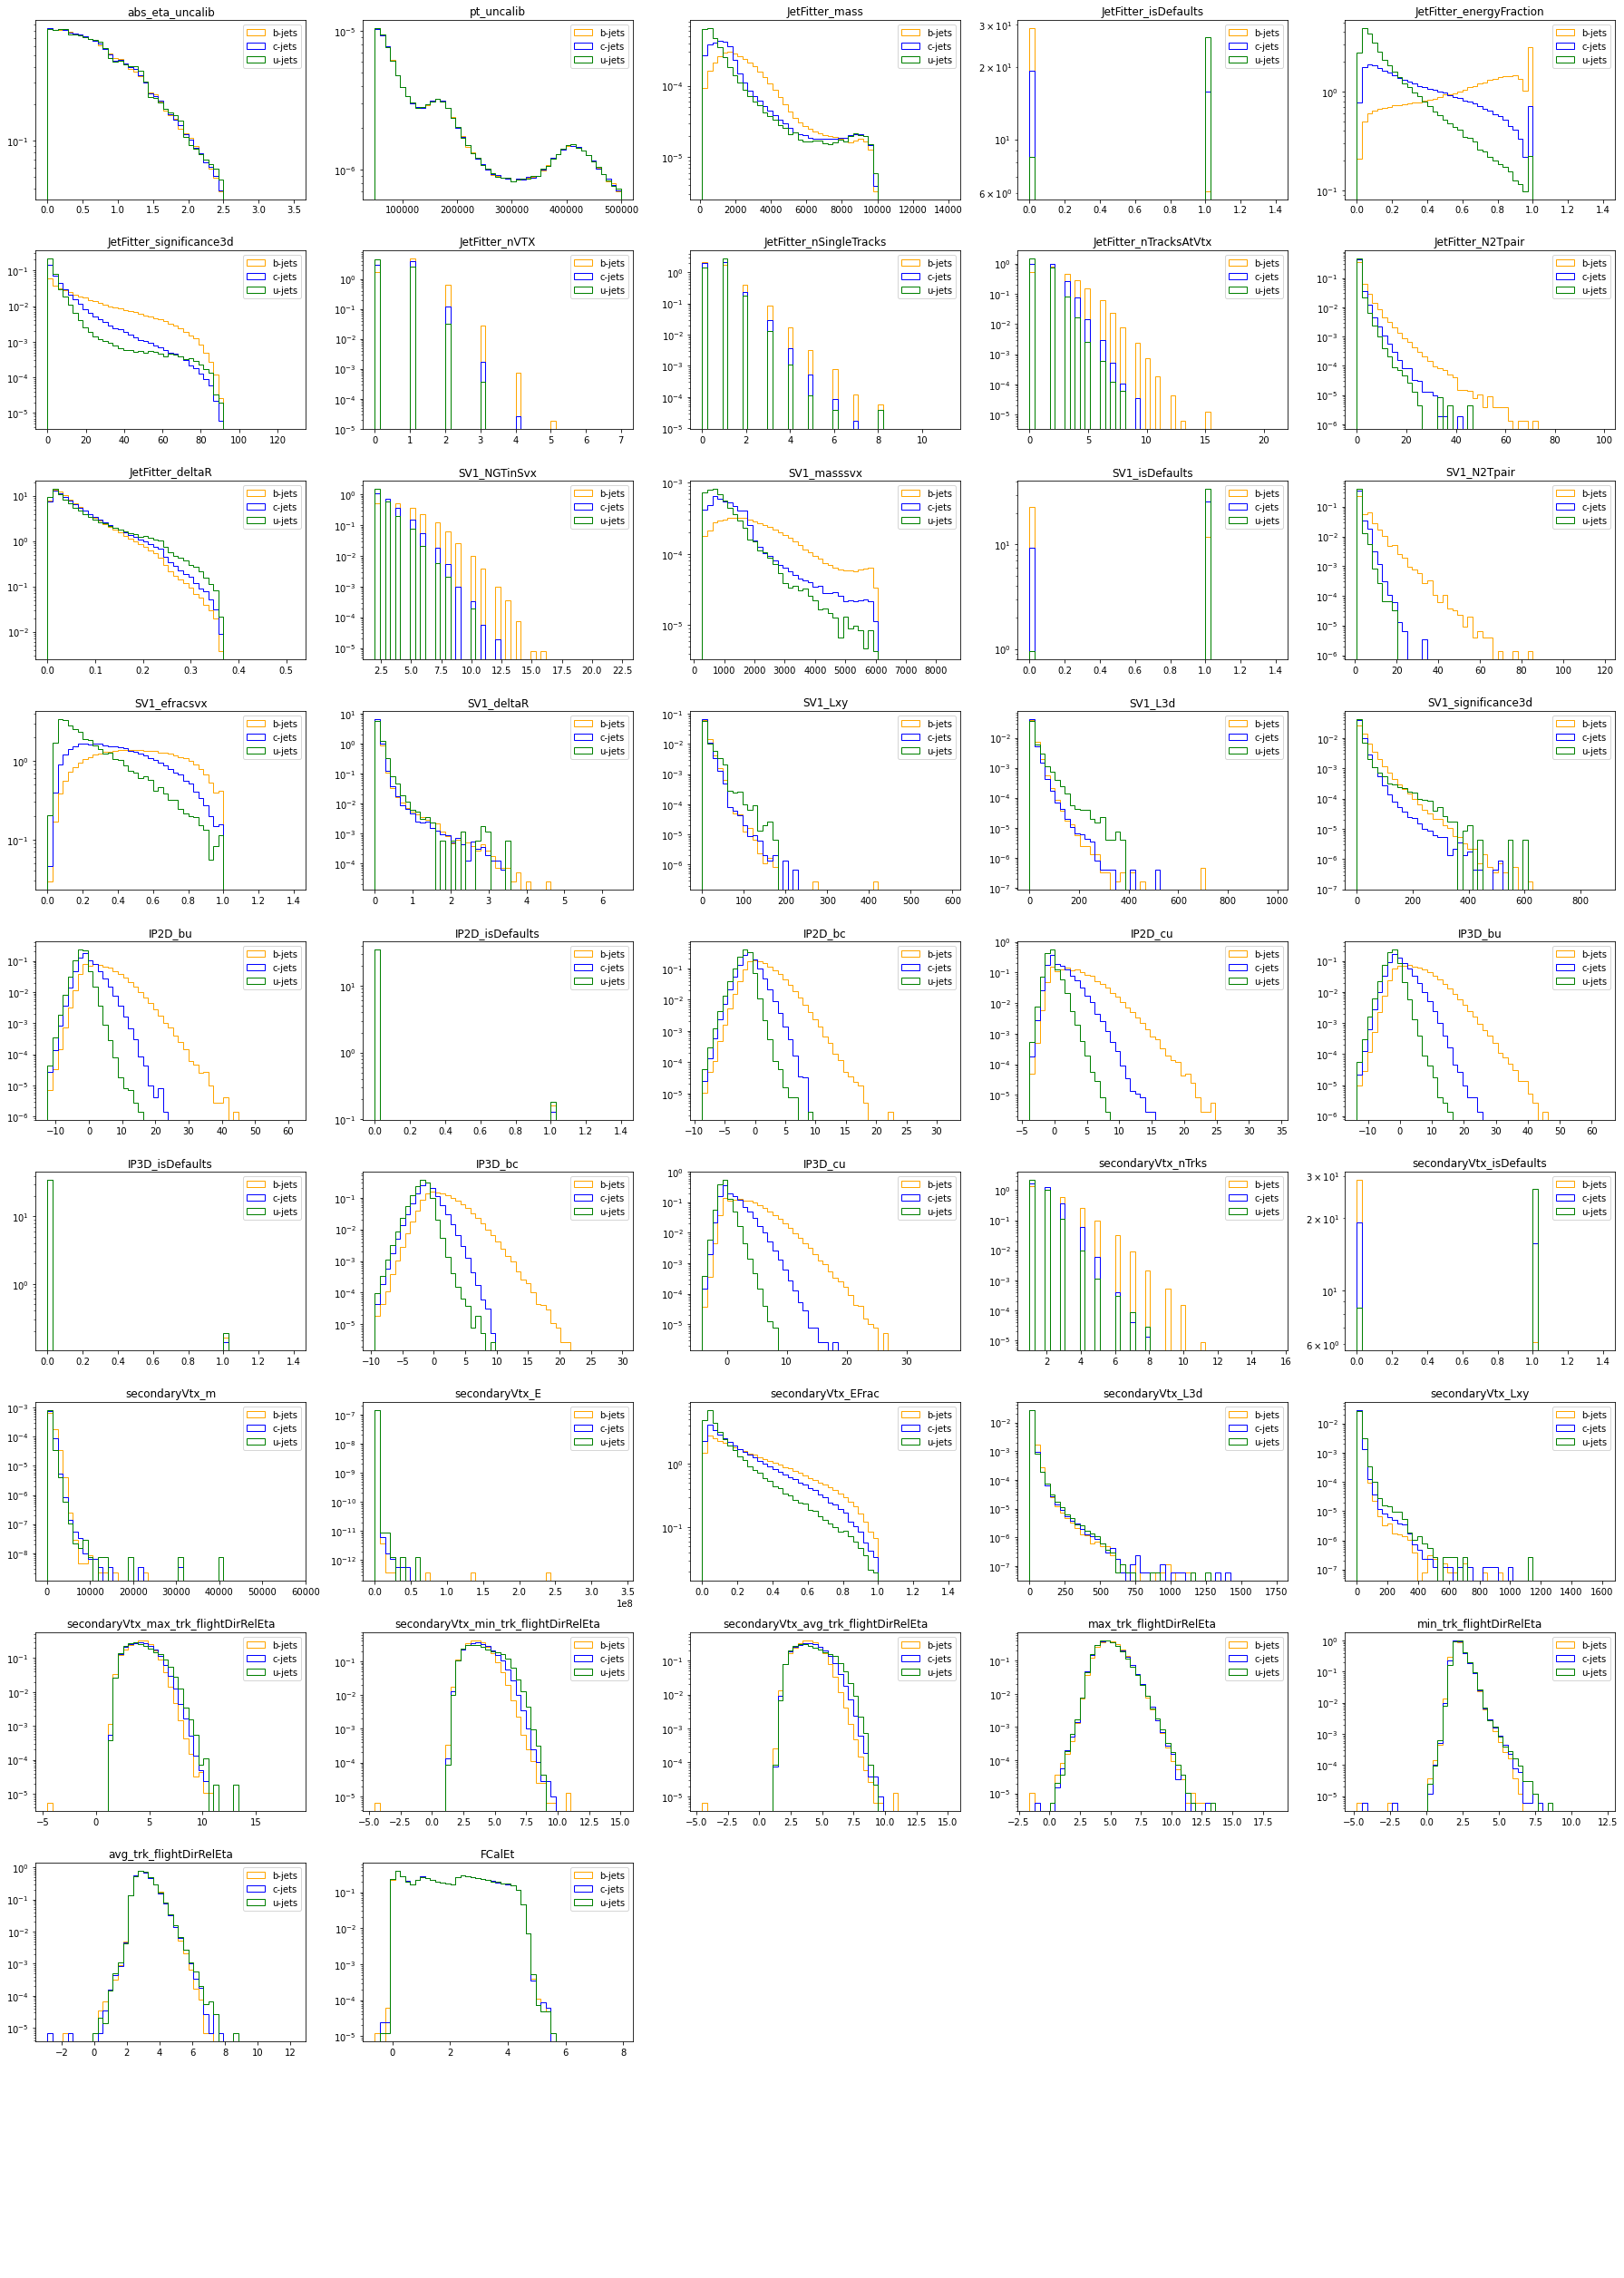

In [50]:
fig, ax = plt.subplots(10, 5, figsize=(25, 35))
nbins = 50

with open("HI_DL1r_Variables.json") as vardict:
    variablelist = json.load(vardict)[:]
variablelist.remove("HadronConeExclTruthLabelID")
varcounter = -1
for i, axobjlist in enumerate(ax):
      for j, axobj in enumerate(axobjlist):
        varcounter+=1
        if varcounter < len(variablelist):
            var = variablelist[varcounter]
        
            b = pd.DataFrame({var: bjets[var]})
            c = pd.DataFrame({var: cjets[var]})
            u = pd.DataFrame({var: ujets[var]})
            b.replace([np.inf, -np.inf], np.nan, inplace=True)
            c.replace([np.inf, -np.inf], np.nan, inplace=True)
            u.replace([np.inf, -np.inf], np.nan, inplace=True)
    
            b = b.dropna()
            c = c.dropna()
            u = u.dropna()

            
            minval = np.amin(b[var])
            if 'pt' in var:
                maxval = np.percentile(u[var],99.99)
            else:
                maxval = max([np.amax(u[var]), np.amax(b[var])])*1.4
            binning = np.linspace(minval,maxval,nbins)


            axobj.hist(b[var],binning,histtype=u'step', color='orange',label='b-jets',density=1)
            axobj.hist(c[var],binning,histtype=u'step', color='b',label='c-jets',density=1)
            axobj.hist(u[var],binning,histtype=u'step', color='g',label='u-jets',density=1)

            
            axobj.legend()
            axobj.set_yscale('log',nonpositive='clip')
            axobj.set_title(variablelist[varcounter])

        else:
            axobj.axis('off')

plt.tight_layout()
plt.savefig("DL1r-variables_1GeV.pdf", transparent=True)
plt.show()

In [51]:
bjets_scaled, cjets_scaled, ujets_scaled = ScaleVariables(bjets, cjets, ujets)

Also, scale the track variables. Here we just have to be careful not to include the masked values in the calculation of the mean and variance.




We don't need all the variables that the training dataset dumper prints out. Variables that are natually close to or centered around 0 we don't scale.

Furthermore, for some of the variables that follow a power law spectrum ($p_T^{frac}$ and $\Delta R$), we take the log of to make them more Gaussian like before transforming.

In [52]:

print('concatenating flavour samples')

X_train = np.concatenate((ujets_scaled, cjets_scaled, bjets_scaled))
y_train = np.concatenate((np.zeros(len(ujets_scaled)),
                          np.ones(len(cjets_scaled)),
                          2 * np.ones(len(bjets_scaled))))

Y_train = np_utils.to_categorical(y_train, 3)
X_train = repack_fields(X_train[var_names])
X_train = X_train.view(np.float64).reshape(X_train.shape + (-1,))

rng_state = np.random.get_state()
# shuffle the arrays
print('shuffle arrays')
np.random.shuffle(X_train)
np.random.set_state(rng_state)
np.random.shuffle(Y_train)
print ('X_train',type(X_train), 'len(): ', len(X_train))
print ('Y_train',type(Y_train), 'len(): ', len(Y_train))
assert X_train.shape[1] == len(var_names)

concatenating flavour samples
shuffle arrays
X_train <class 'numpy.ndarray'> len():  1412217
Y_train <class 'numpy.ndarray'> len():  1412217


In [ ]:
outfile_name = "three_datasets/training_2.h5"
h5f = h5py.File(outfile_name, 'w')
h5f.create_dataset('X_train', data=X_train, compression='gzip')
h5f.create_dataset('Y_train', data=Y_train, compression='gzip')
h5f.close()

In [ ]:
del bjets, ujets, cjets, bjets_scaled, ujets_scaled, cjets_scaled

In [ ]:
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")